<a href="https://colab.research.google.com/github/yash26061981/Airline_Analysis_NLP_Sentiment_Recommender/blob/main/Airline_Analysis_Demo_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive to access files and save models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Reading filtered airline data.

In [ ]:
df_dtype = pd.read_csv('./drive/MyDrive/Colab_Notebooks/PreprocessedDataLightTypes.csv')
dict_dtype = df_dtype[['index','dtypes']].set_index('index').to_dict()['dtypes']
dict_dtype['recommended'] = 'bool'

airline_data_filtered_file = './drive/MyDrive/Colab_Notebooks/PreprocessedDataLight.csv'
airline_data = pd.read_csv(airline_data_filtered_file, dtype=dict_dtype, keep_default_na=False, na_values=['_'])
airline_data.drop(columns=['Unnamed: 0'],inplace=True)
#airline_data = pd.read_csv(airline_data_filtered_file)
airline_data.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_month,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,5.0,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,5.0,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,5.0,2019.0,24.0,4.0,2019.0,12.0,875,pos,False,True
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False


In [ ]:
airline_data.groupby(['recommended']).size().sort_values(ascending=False).reset_index(name='frequency')

,recommended,frequency
0,False,11759
1,True,11063


In [ ]:
train_df = airline_data[['review_text', 'recommended']]
train_df.rename(columns={'review_text':'reviews'}, inplace=True)
data = train_df.copy()
print(data.head(2))
data['reviews'] = data.reviews.str.replace('[^a-zA-Z ]', ' ')

# Converting type of columns to category
data['recommended']=data['recommended'].astype('category')
 
 
#Assigning numerical values and storing it in another columns
data['recommended_new']=data['recommended'].cat.codes
 
#Create an instance of One-hot-encoder
enc=OneHotEncoder()
 
#Passing encoded columns
enc_data=pd.DataFrame(enc.fit_transform(data[['recommended_new']]).toarray())
 
#Merge with main
data=data.join(enc_data)
data.head()
data.drop(columns=['recommended',0,1],inplace=True)
data.rename(columns = {'recommended_new':'recommended'}, inplace = True)
print(data.head())


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-6-c0643716e0ed>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['reviews'] = data.reviews.str.replace('[^a-zA-Z ]', ' ')


                                             reviews  recommended
0   First time Iâ€™d flown TK. I found them very ...         True
1   We make our check in in the airport, they Tak...        False
                                             reviews  recommended
0   First time I   d flown TK  I found them very ...            1
1   We make our check in in the airport  they Tak...            0
2   I flew with this company several times in the...            0
3   Turkish Airlines has consistently maintained ...            1
4   Never book Turkish airlines if you are travel...            0


<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

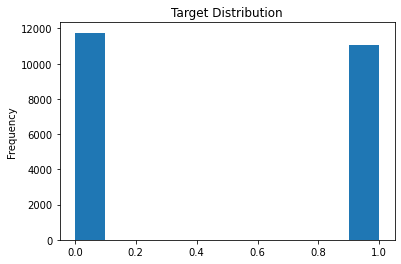

In [ ]:
data.recommended.plot(kind='hist',title='Target Distribution')

# Spiltting the dataset in train, test, validation.

In [ ]:
#train, validate, test = np.split(data.sample(frac=1, random_state=42), [int(.6*len(data)), int(.8*len(data))])
X = data.reviews.values
y = data.recommended.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)


#Selecting Model. 

#Tokenization and Input Formatting

In [ ]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:   First time I   d flown TK  I found them very good in the air  cabin crew  planes  food  all very nice  Not so great on the ground  ground staff  call centre  computer systems  My flight from LHR was delayed so I missed the connection in Istanbul  Most ground staff don   t speak English  and I was given contradictory instructions from those that could speak a little English  I eventually got on a flight to Izmir three hours later  but it wasn   t an easy process  made worse by the vast distances one has to walk between gates in the cavernous new airport  Also  I   d phoned a TK call centre  based in Ukraine  to pay an extra      or so each way for extra leg room seats  However  as the departure times kept changing  my seats kept changing  and for the return leg to London from Istanbul I was not given an extra leg room seat  Luckily there was a spare exit row seat and the cabin crew sorted me out  Overall  I think their cabin crew and planes are very good  ground staff and ca

#TF-IDF Vectorizer
TF-IDF (term frequency–inverse document frequency), tells how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 5min 48s, sys: 42.6 s, total: 6min 30s
Wall time: 6min 38s


#Train Naive Bayes Classifier
##Hyperparameter Tuning
We will use cross-validation and AUC score to tune hyperparameters of our model. The function get_auc_CV will return the average AUC score from cross-validation.

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.0


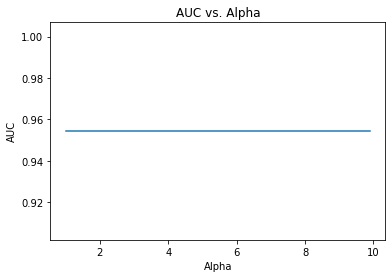

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB

def get_auc_CV(model):
    kf = StratifiedKFold(5, shuffle=True, random_state=1)
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()


mean_data = []
for i in np.arange(1, 10, 0.1):
  val = get_auc_CV(MultinomialNB())
  mean_data.append(val)
res = pd.Series(np.array(mean_data),index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9515
Accuracy: 88.66%


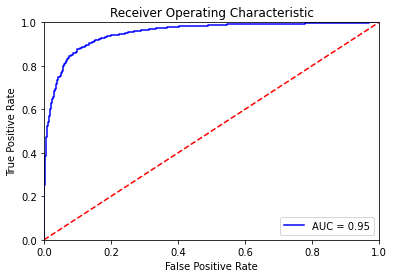

In [ ]:
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

evaluate_roc(probs, y_val)

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **88.66%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our Seq2Seq LSTM Models.

#Save the naive-bayes classifier

In [ ]:
import pickle
f = open('./drive/MyDrive/Colab_Notebooks/naive_bayes_recommender_model/nb_model.pickle', 'wb')
pickle.dump(nb_model, f)
f.close()

#Load model and do inferences

In [ ]:
import pickle
f = open('./drive/MyDrive/Colab_Notebooks/naive_bayes_recommender_model/nb_model.pickle', 'rb')
nb_classifier = pickle.load(f)
f.close()

sample_text = [('Very positive experience with Indigo. Easy baggage-drop at Lucknow airport, new aircraft,' 
                'well trained crew. Very good airline, warmly recommended.'),
               ('Indigo charges extra for its seat selection. And now I dont understand why the flight attendant asked '
               'me to change my seat which is lower than what i paid. I left with no choice cause its for an child ' 
                'with 2.5yrs. Its crazy Indigo has to fine tune its reservation system. The family who booked'
                'the seats got the seats in 3 different places.'),
               ('Recently as an international travel booked return flight, continue to experience problems of scheduling '
               'and rescheduling by the airline, with no head or tail. Difficult to contact either online or web chat '
               'or on the phone to speak to customer service from abroad from abroad. The whole service is below par.'),
               ('No doubt Indigo is best LCC in India, smooth check in, on time sequential boarding and departure. Okay seats, '
               'clean hygiene cabin, courteous cabin crew. Another good experience and reason to fly again with them next time.'),
               ('I used the Indigo flight from Jaipur to Bengaluru. It was ok.')]


sampl_preprocessed = np.array([text_preprocessing(text) for text in sample_text])

sample_tfidf = tf_idf.transform(sampl_preprocessed)

sample_probs = nb_model.predict_proba(sample_tfidf)
print(sample_probs)
# Index 0:             Index:1
# Not recommended,     Recommended


[[0.11462066 0.88537934]
 [0.82415218 0.17584782]
 [0.77621416 0.22378584]
 [0.24109029 0.75890971]
 [0.52850974 0.47149026]]
